# Приоритизация гипотез и анализ A/B-теста интернет-магазина.

Аналитики крупного интернет-магазина совместно с отделом маркетинга подготовили список гипотез для увеличения выручки.
Нам необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

**Цель исследования:**

- определить наиболее перспективные гипотезы
- проанализировать A/B-тест
- принять решение по результатам теста

**Ход исследования:**

Исходные данные о 9-ти гипотезах по увеличению выручки прочитаем из файла `/datasets/hypothesis.csv`. Результаты по проведенному A/B-тесту описаны в файлах `/datasets/orders.csv` и `/datasets/visitors.csv`. Для проведения исследования необходимо изучить и подготовить данные к анализу. Поэтому сначала проведем предобработку данных: проверим их на наличие пропусков, дубликатов, выбросов и по возможности устраним все обнаруженные проблемы. Далее проведем приоритизацию гипотез с использованием фреймворков `ICE` и `RICE`. На следующем этапе исследования проведем A/B-тест и перейдем к его анализу. Для визуализации и интерпретации данных будем строить графики кумулятивных метрик и относительного изменения. Для определения аномальных пользователей и заказов рассчитаем выборочные перцентили и построим диаграммы рассеяния. В ходе статистического анализа данных сформулируем гипотезы и рассчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами, а также в среднем чеке заказа между группами. Данные расчеты произведем как по «сырым», так и по «очищенным» данным и сравним результаты. На заключительном этапе примем решение по результатам теста и сформулируем общий вывод исследования.

**Основные этапы исследования:**

1. Изучение и предобработка данных.
2. Проведение прироритизации гипотез.
3. Анализ проведенного А/В-теста.
4. Статистический анализ, проверка гипотез.
5. Составление общего вывода.

## Изучение данных и подготовка их к анализу.

Импортируем библиотеки, которые будем использовать для проведения исследовательской работы.

In [1]:
# импорт необходимых библиотек
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', 0)

Для ознакомления с исходными данными загрузим информацию о гипотезах, заказах и посетителях из CSV-файлов в переменные `hypothesis`, `orders`, `visitors`.

In [2]:
# загрузка исходных данных о гипотезах, заказах и посетителях
try:
    hypothesis, orders, visitors = (pd.read_csv('/datasets/hypothesis.csv'),
                                    pd.read_csv('/datasets/orders.csv'),
                                    pd.read_csv('/datasets/visitors.csv'))
except:
    hypothesis, orders, visitors = (pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv'),
                                    pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv'),
                                    pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv'))

Выведем первые строки и основную информацию для каждого датафрейма, а также посчитаем количество строк дубликатов и проверим данные на наличие пропусков.

In [3]:
df_name = hypothesis, orders, visitors # названия всех датафреймов
for df in df_name:
    display(df.head()) # первые строки таблицы
    print()
    df.info() # основная информация 
    print('\nКоличество строк дубликатов:', df.duplicated().sum()) # количество дубликатов
    print('\nКоличество пропущенных значений:\n', df.isna().sum()) # количество пропусков

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes

Количество строк дубликатов: 0

Количество пропущенных значений:
 Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB

Количество строк дубликатов: 0

Количество пропущенных значений:
 transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB

Количество строк дубликатов: 0

Количество пропущенных значений:
 date        0
group       0
visitors    0
dtype: int64


Таблица с данными о гипотезах состоит из 5 столбцов и 9 строк.

**Описание данных таблицы `hypothesis`:**

- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Данные о заказах представлены таблицей из 5 столбцов и 1 197 строк.

**Описание данных таблицы `orders`:**

- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

Датафрейм с информацией о посетителях стостоит из 3 столбцов и 62 строк.

**Описание данных таблицы `visitors`:**

- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста.

В полученных данных каждой таблицы отсутствуют пропущенные значения и строки дубликаты. Убедились, что типы данных во всех колонках соответствуют сохранённым в них значениям, за исключением столбцов с датой.

Также необходимо привести названия столбцов в таблицах с гипотезами и заказами в соответствие с хорошим стилем. Для этого приведем наименоваия к нижнему регистру, а также добавим нижнее подчеркивание в названия с идентиикаторами.

In [4]:
# приведение наименований столбцов в соответствие с хорошим стилем
hypothesis.columns = hypothesis.columns.str.lower()
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']

Для дальнейшего анализа приведем столбцы с датой к соответствующему типу данных даты.

In [5]:
# приведение данных с датой к соответствующему типу данных
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

Проверим, корректно ли поделен трафик в группах А и В. Для этого выведем количество уникальных пользователей в каждой из групп, затем сравним полученные значения с общим количеством уникальных пользователей. Также рассчитаем относительную разницу между группами по количеству уникальных пользователей для оценки сбалансированности деления трафика.

In [6]:
print('\nКоличество уникальных пользователей по группам:\n', orders.groupby('group')['visitor_id'].nunique())
print('\nОбщее количество уникальных пользователей:', len(orders['visitor_id'].unique()))

# расчет относительной разницы между группами А и В
a_visitor =  orders[orders['group'] == 'A']['visitor_id'].nunique()
b_visitor = orders[orders['group'] == 'B']['visitor_id'].nunique()
print('Относительная разница количества клиентов между группами:', "{0:.1%}".format(b_visitor / a_visitor -1))


Количество уникальных пользователей по группам:
 group
A    503
B    586
Name: visitor_id, dtype: int64

Общее количество уникальных пользователей: 1031
Относительная разница количества клиентов между группами: 16.5%


Присутствует несбалансированное деление трафика, пользователей категории В на 16.5 % больше чем в сегменте А. Вполне допустимо, что в одной группе больше участников, чем в другой. Это не говорит о некорректности теста, лишь о его неоптимальности. Чем больше разница в количестве участников, тем дольше будет проходить этап подготовки к тесту, поэтому продолжаем анализ.

Также видим, что в каждой группе присутствуют неуникальные клиенты. Вероятно, перед анализом А/B-теста их стоит удалить, так как они могут давать смещение оценки целевого события: если пользователь, участвующий в обеих группах, совершил целевое событие теста, мы не сможем достоверно оценить, произошло это под влиянием нововведения, или же это его обычное поведение. Но прежде найдем количество неуникальных клиентов, а также оценим их долю от общего числа пользователей, чтобы понимать масштаб бедствия.

In [7]:
# расчет кол-ва неуникальных клиентов и их доли от общего числа пользователей
non_unique_cnt = (a_visitor + b_visitor) - len(orders['visitor_id'].unique())
print('Количество неуникальных клиентов:', non_unique_cnt)
print('Доля неуникальных пользователей:', "{0:.1%}".format(non_unique_cnt / len(orders['visitor_id'].unique())))

Количество неуникальных клиентов: 58
Доля неуникальных пользователей: 5.6%


Напомним, что всего 1031 уникальных клиентов. 58 пользователей присутствуют в каждой из групп, что составляет 5,6 % от общего числа клиентов. Так как доля неуникальных пользователей невелика, имеет смысл исключить их из таблицы для более корректного анализа A/B-теста.

In [8]:
# исключение неуникальных пользователей из таблицы с заказами
same = orders.query('group == "A"').merge(orders.query('group == "B"'), on='visitor_id')
non_unique_visitors = same['visitor_id'].to_list()
orders = orders[~orders['visitor_id'].isin(non_unique_visitors)]
print('Общее количество уникальных пользователей:', len(orders['visitor_id'].unique()))

Общее количество уникальных пользователей: 973


Таким образом, оставили в таблице с заказами только уникальных пользователей. Далее проверим, совпадает ли временной диапазон в таблицах с информацией о пользователях и заказах.

In [9]:
# вывод временного диапазона таблиц orders и visitors
print(f'Временной диапазон таблицы с заказами:', orders['date'].min(), '-', orders['date'].max())
print(f'Временной диапазон таблицы с пользователями:', visitors['date'].min(), '-', visitors['date'].max())

Временной диапазон таблицы с заказами: 2019-08-01 00:00:00 - 2019-08-31 00:00:00
Временной диапазон таблицы с пользователями: 2019-08-01 00:00:00 - 2019-08-31 00:00:00


Убедились, что в исходных таблицах представлены данные за август 2019 года.

**Вывод:**

На этапе знакомства с данными, изучили информацию о гипотезах по увеличению выручки интернет-магазина, а также о пользователях и заказах за август 2019 года. В процессе изучения данных убедились, что в таблицах нет пропущенных значений и строк дубликатов. В процессе проверки типов данных на соответствие сохранённым в них значениям, обнаружили некорректный тип в столбцах с датой, обработкой которого занялись на этапе подготовки данных к анализу. Также привели названия столбцов в соответствие с хорошим стилем и исключили неуникальных пользователей для более корректного анализа A/B теста. Таким образом, этап изучения общей информации и предобработки данных завершен, данные изучены и подготовлены к дальнейшему анализу.

## Приоритизация гипотез.

В таблице `hypothesis` содержится информация о 9-ти гипотезах по увеличению выручки интернет-магазина с указанными параметрами `Reach`- охват, `Impact` - влияние, `Confidence` - уверенность, `Effort` - усилия. Для определения наиболее перспективных гипотез воспользуемся методами `ICE` и `RICE`.

Преимущество подхода `ICE` в его простоте: чтобы оценить задачу, достаточно присвоить значения от одного до десяти для каждого из факторов и вычислить `ICE Score` по формуле:

`ICE Score = (Impact * Confidence) / Effort`

Применим фреймворк `ICE` для приоритизации гипотез и отсортируйем их по убыванию приоритета.

In [10]:
# приоритизация гипотез фреймворком ICE
hypothesis['ICE'] = ((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']).round(2)
display(hypothesis[['hypothesis', 'ICE']].sort_values('ICE', ascending=False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Наиболее перспективные гипотезы под номерами 8, 0, 7, 6 и 2. 

Далее проверим, изменится ли ситуация при использовании другого метода приоритизации.
В отличие от `ICE`, метод `RICE` более сбалансирован и рассчитывается по следующей формуле: 

`RICE Score = (Reach * Impact * Confidence) / Effort`.

Применим фреймворк `RICE` для приоритизации гипотез и также отсортируйем их по убыванию приоритета.

In [11]:
# приоритизация гипотез фреймворком RICE
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
display(hypothesis.sort_values('RICE', ascending=False))

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


В числе приоритетных гипотез остались те же гипотезы, но в другом порядке. Наиболее перспективными гипотезами с учетом охвата пользователей являются гипотезы под номерами 7, 2, 0 и 6. Для гипотезы № 7 показатель охвата пользователей имеет максимальный балл, поэтому данная гипотеза занимает первое место по приоритету при использовании фреймворка `RICE`.

**Вывод:**

Нам удалось сформулировть 9 гипотез по увеличению выручки, но не стоит спешить проверять их все одновременно. Список для проверки должны возглавлять самые значимые для бизнеса гипотезы. На контрасте с ними мы можем обнаружить слабые, которые можно отбросить, чтобы не тратить ресурсы на их проверку. Сильными мы будем считать те гипотезы, которые имеют существенный ожидаемый эффект для бизнеса и не очень сложны в реализации. Если вера в эффект низкая, а сложность реализации высокая, то стоит отложить такую гипотезу. Чтобы выбрать из имеющихся гипотез наиболее перспективные мы воспользовались методом `ICE` и получили топ-5 гипотез под номерами 8, 0, 7, 6 и 2. Далее приритизировали гипотезы методом `RICE`, в результате в топ-5 гипотез вошли те же гипотезы, но  в другом порядке. 

Таким образом, приоритизация гипотез меняется в зависимости от метода, поэтому при использовании фреймворка `RICE` параметр `reach` оказывает влияние на расстановку приоритета. Благодаря наибольшему охвату пользователей и максимальному значению даннного показателя гипотеза под номером 7 занимает лидирующую позицию. Поэтому начнем проводить A/B тест для самой приоритетной гипотезы "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".

##  Исследовательский анализ A/B-теста.

Мы провели A/B-тест и получили результаты, которые содержатся в таблицах в `orders` и `visitors`. Начнем анализ A/B-теста с построения графиков кумулятивных метрик. Прежде чем перейти к построению графиков, создадим датафрейм `datesGroups` с уникальными парами значений `date` и `group` таблицы `orders`. Избавимся от дубликатов методом `drop_duplicates()`.

In [12]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date', 'group']].drop_duplicates()

Объявим переменную `ordersAggregated`, содержащую:
- дату;
- группу A/B-теста;
- число уникальных заказов в группе теста по указанную дату включительно;
- число уникальных пользователей, совершивших хотя бы 1 заказ в группе теста по указанную дату включительно;
- суммарную выручку заказов в группе теста по указанную дату включительно.

In [13]:
# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], \
orders['group'] == x['group'])].agg({'date': 'max', 'group': 'max', 'transaction_id': 'nunique',  \
'visitor_id': 'nunique', 'revenue': 'sum'}), axis=1).sort_values(by=['date', 'group'])

Объявим переменную `visitorsAggregated`, содержащую:

- дату;
- группу A/B-теста;
- количество уникальных посетителей в группе теста по указанную дату включительно.

In [14]:
# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], \
visitors['group'] == x['group'])].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}), axis=1)\
.sort_values(by=['date', 'group'])

Определим переменную `cumulativeData`, объединив `ordersAggregated` и `visitorsAggregated` по колонкам `date` и `group` методом `merge()`. Переименуем столбцы полученной переменной и выведем первые строки.

In [15]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
display(cumulativeData.head(5))

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


- **Графики кумулятивной выручки по группам**

Построим графики кумулятивной выручки по дням и группам A/B-тестирования.

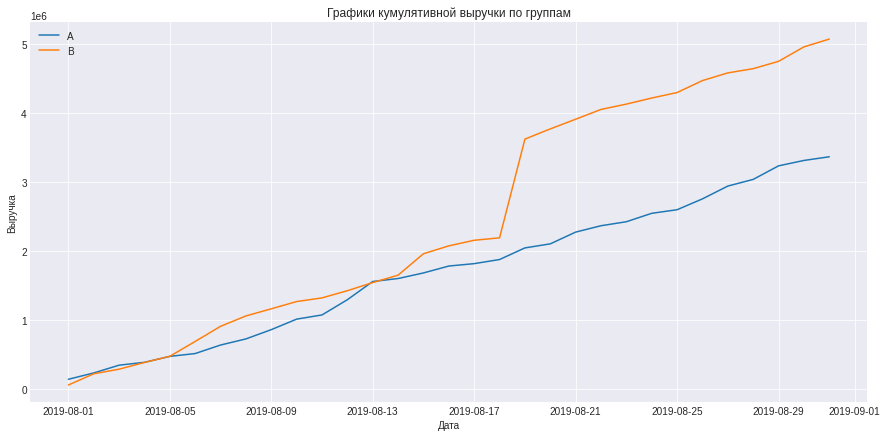

In [16]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

matplotlib.style.use('seaborn-darkgrid')
plt.figure(figsize=(15, 7))

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('Графики кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.legend();

Выручка почти равномерно увеличивается в течение всего теста, это хороший знак. Однако график выручки группы `В` резко возрастает 18 августа. Это может сигнализировать о всплеске числа заказов, либо о появлении очень дорогих заказов в выборке. Таким образом, к концу месяца кумулятивная выручка группы `В` значительно превосходит выручку группы `А`.

 - **Графики кумулятивного среднего чека по группам**
 
Построим графики среднего чека по группам. Для этого разделим кумулятивную выручку на кумулятивное число заказов.

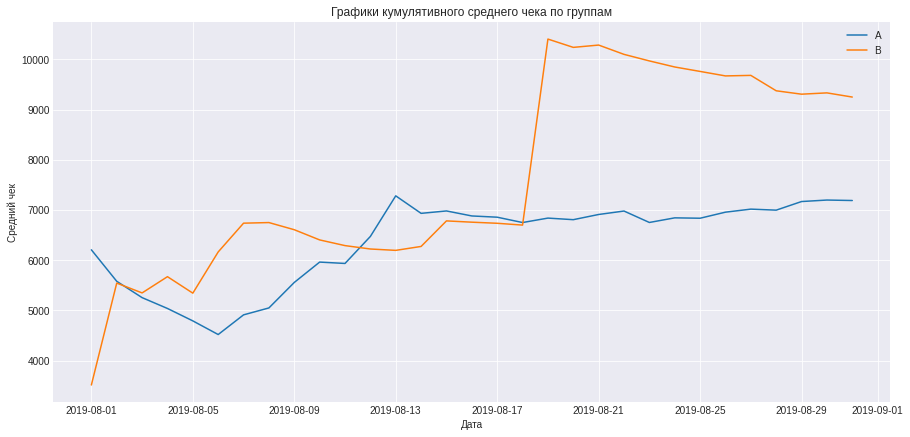

In [17]:
plt.figure(figsize=(15, 7))

# строим графики среднего чека по группам
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('Графики кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.legend();

Средний чек становится более равномерным ближе к концу теста: установился для группы `A` и продолжает падать для группы `B`. Возможно, в группу `B` 18 августа попали крупные заказы (резкий всплеск на графике). Тогда ей нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне. К концу августа 2019 года кумулятивный средний чек группы `В` превосходит чек группы `А`.

- **График относительного изменения кумулятивного среднего чека группы `B` к группе `A`**

Построим график относительного различия для среднего чека. Добавим горизонтальную ось методом `axhline()`.

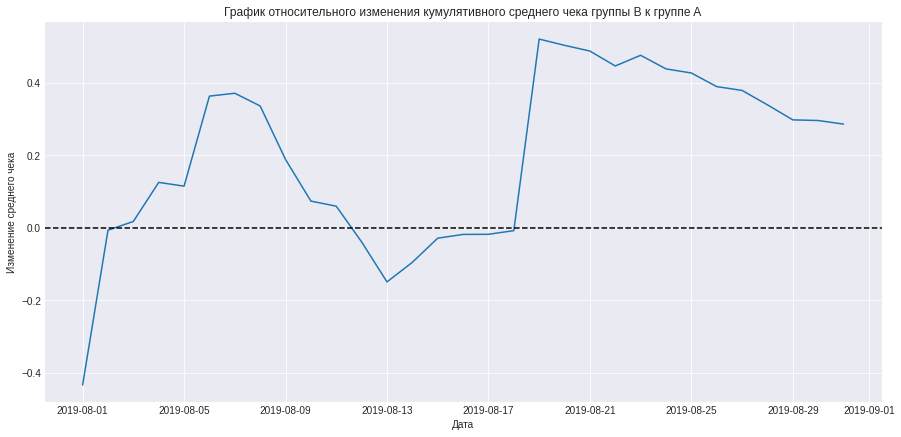

In [18]:
plt.figure(figsize=(15, 7))

# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left',\
suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB']) \
/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Изменение среднего чека');

Таким образом, полученный график подтверждает выводы по предыдущим графикам кумулятивной выручки и кумулятивного среднего чека по группам. В целом средний чек группы В выше. В нескольких точках график различия между сегментами резко «скачет», что подтверждает наличие крупных заказов и выбросов.

- **Графики кумулятивного среднего количества заказов на посетителя по группам**

Аналогично проанализируем график кумулятивного среднего количества заказов на посетителя по группам. Для этого добавим в таблицу `cumulativeData` столбец `conversion` c отношением числа заказов к количеству пользователей в указанной группе в указанный день. Объявим переменные `cumulativeDataA` и `cumulativeDataB`, в которых сохраним данные о заказах в сегментах `A` и `B` соответственно. Зададим масштаб осей методом `plt.axis()`. Передадим ему минимальное и максимальное значения оси x, а также минимальное и максимальное значения оси y. Теперь можем построить графики кумулятивного среднего количества заказов на посетителя по группам.

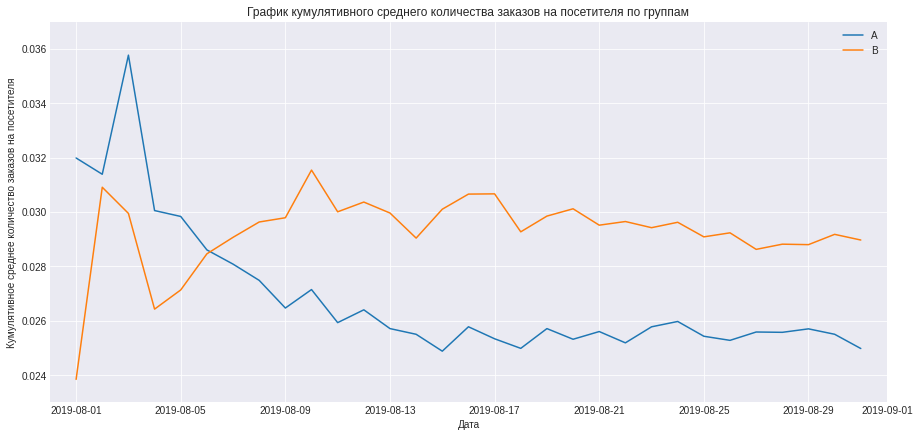

In [19]:
# считаем кумулятивное среднее количество заказов на посетителя
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(15, 7))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

# задаем масштаб осей и названия
plt.axis([dt.datetime(2019, 7, 31), dt.datetime(2019, 9, 1), 0.023, 0.037])
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивное среднее количество заказов на посетителя');

6 августа кумулятивное среднее количество заказов на посетителя сравнялось, но затем показатель группы `B` вырвался вперёд и зафиксировался, а для группы `A` данный показатель просел и также зафиксировался.

- **График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A**

Построим график относительного различия кумулятивного среднего количества заказов на посетителя между сегментами. Для этого объединим таблицы `cumulativeDataA` и `cumulativeDataB` методом `merge()` так, чтобы она содержала столбцы: `date`, `conversionA`, `conversionB`. Сохраним таблицу в переменной `mergedCumulativeConversions`. Добавим пунктирную линию оси X чёрного цвета со значением оси `Y = 0` методом `plt.axhline()`. И ещё одну линию оси X серого цвета со значением оси `Y = 0.16`. Выведем график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. 

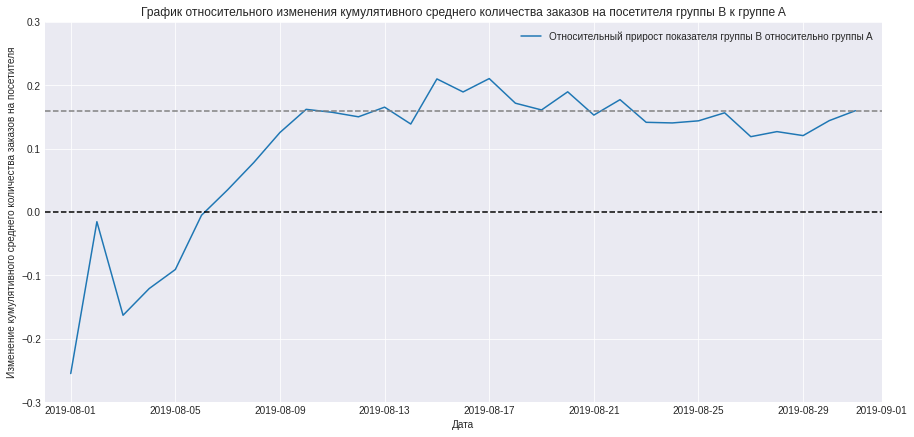

In [20]:
# собираем таблицу с датой и относительным изменением кумулятивного среднего количества заказов на посетителя
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']],\
left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(15, 7))
# строим график относительного изменения
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB'] \
/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост показателя группы B относительно группы A")
plt.legend()

# добавляем оси Х, задаем масштаб осей и названия
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.16, color='grey', linestyle='--')
plt.axis([dt.datetime(2019, 7, 31), dt.datetime(2019, 9, 1), -0.3, 0.3])
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Изменение кумулятивного среднего количества заказов на посетителя');

В начале теста группа B значительно проигрывала группе A, но 6 августа вырвалась вперёд. C тех пор группа B лидирует по показателю относительного изменения кумулятивного среднего количества заказов на посетителя, который становится лучше, либо зафиксировался около прироста в 16% относительно группы A. Впрочем, сейчас делать какие-либо выводы по тесту нельзя, сперва стоит проанализировать аномалии, возможно, они изменят картину.

- **Точечный график количества заказов по пользователям**

Напомним, что конверсия равна отношению числа заказов к количеству посетителей сайта за время теста. Пользователи, совершившие много заказов, влияют на числитель формулы конверсии. Скорее всего, их поведение отличается от нормального. Если речь не идёт об интернет-магазине с регулярным спросом, «обычный» пользователь совершает не больше двух заказов за короткий срок. Подсчитаем количество заказов по пользователям и посмотрим на результат.

Чтобы найти число заказов по пользователям, создадим датафрейм `ordersByUsers` c двумя столбцами `visitor_id` и `orders`. Отсортируем по убыванию количества заказов пользователей и выведите на экран первые 5 строк.

In [21]:
# соберем таблицу с количеством заказов по пользователям
ordersByUsers = orders.groupby('visitor_id', as_index=False) \
    .agg({'transaction_id': 'nunique'}).rename(columns={'transaction_id': 'orders'})

display(ordersByUsers.sort_values(by='orders', ascending=False).head(5)) 

,visitor_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3


Клиенты сделали не более трех заказаов. Такой показатель соответствует поведению обычного пользователя за месяц. Построим точечную диаграмму числа заказов на одного пользователя методом `scatter()`, передав ему значения по осям X и Y. 
Значения по горизонтальной оси зададим в переменной `x_values` — сгенерированные номера наблюдений. Значения для вертикальной оси возьмем из столбца `orders` датафрейма `ordersByUsers`.

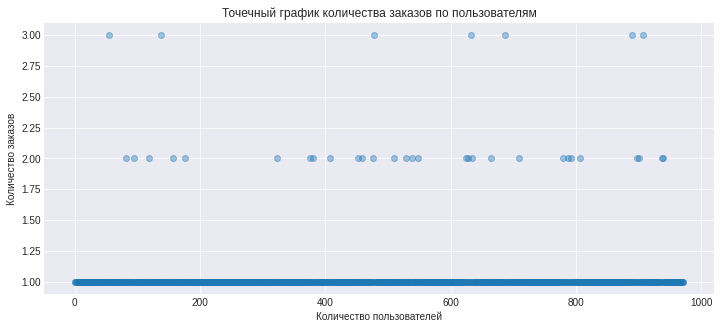

In [22]:
# зададим диапазон значений оси Х и посторим диаграмму рассеяния
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.figure(figsize=(12, 5))
plt.scatter(x_values, ordersByUsers['orders'], alpha=0.4)
plt.title('Точечный график количества заказов по пользователям')
plt.xlabel('Количество пользователей')
plt.ylabel('Количество заказов');

Выводы подтверждаются: большинство пользователей совершили один заказ, небольшое количество покупателей заказали дважды, и единицы купили три раза.

- **95-й и 99-й перцентили количества заказов на пользователя**

Посчитаем выборочные перцентили количества заказов на одного пользователя.

In [23]:
# рассчет 95-го и 99-го перцентелей
print('95-й перцентиль количества заказов по пользователям =', np.percentile(ordersByUsers['orders'], [95]))
print('99-й перцентиль количества заказов по пользователям =', np.percentile(ordersByUsers['orders'], [99]))

95-й перцентиль количества заказов по пользователям = [1.]
99-й перцентиль количества заказов по пользователям = [2.]


Не более 5% пользователей оформляли более одного заказа. И не более 1% пользователей совершили более двух заказов. Так как максимальное количество заказов по пользователям равно трем, разумно выбрать 2 заказа на одного пользователя за верхнюю границу числа заказов, и отсеять аномальных пользователей по ней.

- **Точечный график стоимостей заказов**

Проверим данные на наличие аномально дорогих заказов, которые могут исказить результаты тестирования. При этом такие покупки — редкость, исключение, которое проявилось не из-за тестирования гипотезы, а случайно. Поэтому такие выбивающиеся заказы следует удалять из теста.

Построим диаграмму рассеяния методом `scatter()`, передав ему значения по осям X и Y. Значения по горизонтальной оси зададим в переменной `x_values` — сгенерированные номера наблюдений. Значения для вертикальной оси возьмем из столбца `revenue` датафрейма `orders`.

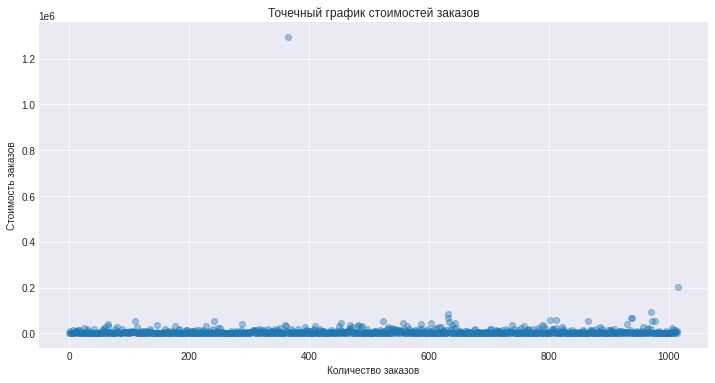

In [24]:
# зададим диапазон значений оси Х и посторим диаграмму рассеяния
x_values = pd.Series(range(0, len(orders['revenue'])))

plt.figure(figsize=(12, 6))
plt.scatter(x_values, orders['revenue'], alpha=0.4)
plt.title('Точечный график стоимостей заказов')
plt.xlabel('Количество заказов')
plt.ylabel('Стоимость заказов');

Точечный график стоимостей заказов подтверждает, что имеется небольшое число дорогих заказов. На фоне двух достаточно крупных заказов остальные, менее аномальные заказы, сбились в одну кучу на оси Х. Поэтому построим такой же график, но без учета самых крупных покупок, чтобы исследовать распределение менее аномальных покупок.

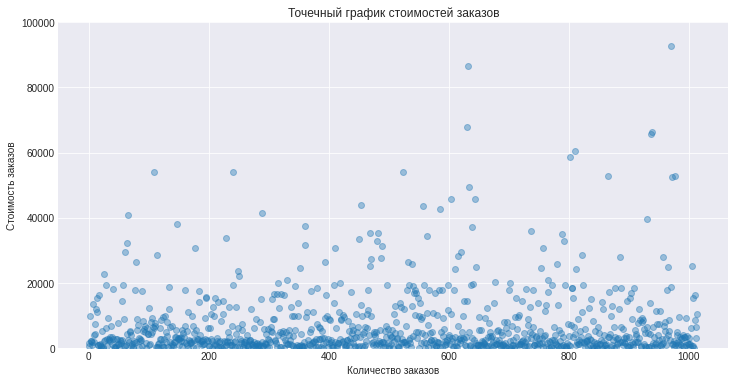

In [25]:
# диаграмма рассеяния стоимости заказов без учета дорогих покупок
plt.figure(figsize=(12, 6))
plt.scatter(x_values, orders['revenue'], alpha=0.4)
plt.ylim(0, 100000)
plt.title('Точечный график стоимостей заказов')
plt.xlabel('Количество заказов')
plt.ylabel('Стоимость заказов');

На точечном графике стоимостей заказов без учета самых крупных покупок, видим, что стоимость заказов не превышает 100 000 рублей. В основном стоимость заказа варьируется в пределах 40 000 руб., а наибольшая часть заказов не превышает и 10 000 руб. Но по диаграмме рассеяния сложно выбрать границу аномальных заказов. Принято отсеивать от 1% до 5% наблюдений с крайними значениями, поэтому следует рассчитать выборочные перцентили.

- **95-й и 99-й перцентили стоимости заказов**

Для определения стоимости аномально дорогих заказов рассчитаем 95-й и 99-й выборочные перцентили выручки с заказов по пользователям методом `np.percentile()`.

In [26]:
# расчет 95-го и 99-го перцентелей
print('95-й перцентиль выручки с заказов =', np.percentile(orders['revenue'], [95]))
print('99-й перцентиль выручки с заказов =', np.percentile(orders['revenue'], [99]))

95-й перцентиль выручки с заказов = [26785.]
99-й перцентиль выручки с заказов = [53904.]


Не более 5% заказов дороже 26 785 рублей. И не больше, чем у 1% заказов чек дороже 53 904 рублей. Отнесем к аномально дорогим заказам такие, стоимость которых превышает 53 904 рублей.

**Вывод:**

На этапе исследовательского анализа проведенного A/B-теста построили графики кумулятивных метрик и относительного изменения и пришли к следующим наблюдениям:

- графики кумулятивной выручки по группам, кумулятивного среднего чека по группам, а также график относительного изменения кумулятивного среднего чека группы B к группе A подтверждают, что показатели группы В лучше. Однако, вероятно, что 18 августа в данной группе были крупные заказы и при дальнейшем анализе стоит учитывать возможное влияние выбросов.

- графики кумулятивного среднего количества заказов на посетителя по группам и относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A подтверждают, что 6 августа группа B начинает превосходить группу А. C тех пор группа B лидирует по данным показателям: показатель относительного изменения кумулятивного среднего количества заказов на посетителя между сегментами становится лучше, либо зафиксировался около прироста в 16% относительно группы A.

Для определения аномальных пользователей и заказов рассчитали выборочные перцентили и построили диаграммы рассеяния количества заказов по пользователям и стоимостей заказов. Получили следующие выводы:

- не более 1% пользователей совершили более двух заказов, поэтому при фильтрации аномальных пользователей в качестве верхней границы числа заказов выбрали 2 заказа на одного пользователя.
- не больше, чем у 1% заказов чек дороже 53 904 рублей. При отсеивании выбросов отнесем к аномально дорогим заказам такие, стоимость которых превышает 53 904 рублей.

## Статистический анализ и проверка гипотез.

Для проведения A/B-тестирования воспользуемся методом `st.mannwhitneyu()`или «U-критерием Манна-Уитни». Выбор данного критерия, с помощью которого мы проверим гипотезы, связан с наличием в данных выбросов, сильно сдвигающих параметрические результаты. Как обычно, связанная с измеряемой социальной активностью величина распределена ненормально: отдельные пользователи совершают большое количество заказов - это выбросы. Также на этапе исследовательского анализа A/B-теста мы обнаружили и аномально дорогие заказы. Главное отличие критерия Манна-Уитни в том, что он работает с рангами, — номерами значений в упорядоченном ряду, — никак не учитывая сами значения. Поэтому воспользуемся данным методом при проверке гипотез, т.к. в нашем случае работа с самими значениями невозможна из-за  наличия выбросов.

- **Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным**

Посчитаем статистическую значимость различий в среднем числе заказов на пользователя по «сырым» данным — без удаления аномальных пользователей. Сформулируем гипотезы.

**Н_0:** различий в среднем количестве заказов на посетителя между группами нет. 

**H_a:** различия в среднем количестве заказов на посетителя между группами есть.

Для расчета статистической значимости различий в среднем количестве заказов на посетителя между группами начнём с подготовки данных. Создадим переменные `ordersByUsersA` и `ordersByUsersB` со столбцами `visitor_id`, `orders`. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов. 

In [27]:
# собираем таблицы для групп А и B, с количеством заказов по пользователям (кол-во заказов > 1)
ordersByUsersA = (orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})).rename(columns={'transaction_id': 'orders'})

ordersByUsersB = (orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})).rename(columns={'transaction_id': 'orders'})

Объявим переменные `sampleA` и `sampleB`, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

In [28]:
# собираем таблицы для групп А и B, с количеством заказов по всем пользователям 
sampleA = pd.concat([ordersByUsersA['orders'], \
pd.Series(0, index=np.arange(visitors['visitors'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'], \
pd.Series(0, index=np.arange(visitors['visitors'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

Применим критерий Манна-Уитни и отформатируем `p-value`. Напомним, что в `sampleA` сохранили выборку, где каждый элемент — число заказов определённого пользователя, в том числе ноль. Значит, число элементов `sampleA` — это количество пользователей, сумма всех элементов — количество заказов. Чтобы получить среднее число заказов на пользователя, поделим сумму заказов на число пользователей — найдём среднее в выборке `sampleA` методом `mean()`. Аналогично найдём среднее группы B.

Также рассчитаем относительный прирост среднего числа заказов на посетителя группы B по формуле: `среднее число заказов на посетителя группы B / среднее число заказов на посетителя группы A - 1`.

In [29]:
# расчет p-value и относительного прироста среднего числа заказов на посетителя группы B
print('Критический уровень статистической значимости alpha = 0.05')
print("p-value = {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print("Относительный прирост среднего числа заказов на посетителя группы В = {0:.3f}"\
.format(sampleB.mean() / sampleA.mean() - 1))

Критический уровень статистической значимости alpha = 0.05
p-value = 0.007
Относительный прирост среднего числа заказов на посетителя группы В = 0.171


Наблюдаем, что `p-value` значительно ниже критического уровня статистической значимости. Следовательно, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов на посетителя между группами нет, отвергаем в пользу альтернативной гипотезы. По «сырым» данным имеются различия в среднем числе заказов на посетителя между группами A и B. Относительный выигрыш группы B по среднему количеству заказов на посетителя равен 17,1 %.

- **Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным**

Теперь проверим статистическую значимость различий в среднем чеке между сегментами. Сформулируем гипотезы.

**Н_0:** различий в среднем чеке между группами нет. 

**Н_а:** различия в среднем чеке между группами есть. 

Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию `mannwhitneyu()` данные о выручке с заказов. А также найдём относительные различия в среднем чеке между группами.

In [30]:
# расчет p-value и относительного прироста среднего чека группы B
print('Критический уровень статистической значимости alpha = 0.05')
print('p-value = {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], \
    orders[orders['group']=='B']['revenue'])[1]))
print('Относительный прирост среднего чека группы В = {0:.3f}' \
    .format(orders[orders['group']=='B']['revenue'].mean() / orders[orders['group']=='A']['revenue'].mean()-1))

Критический уровень статистической значимости alpha = 0.05
p-value = 0.829
Относительный прирост среднего чека группы В = 0.287


Таким образом, `р-value` значительно превышает уровень статистической значимости. Значит, нет причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия. Впрочем, средний чек группы B превышает средний чек группы A на 28,7%. Скорее всего, подобный проигрыш группы А связан с наличием аномально дорогих заказов в группе В.

- **Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным**

Напомним, что 95-й и 99-й перцентили средних чеков равны 26 785 и 53 904 рублям. А 95-й и 99-й перцентили количества заказов на одного пользователя равны 1 и 2 заказам на пользователя.
Примем за аномальных пользователей тех, кто совершил более 2 заказов или совершил заказ дороже 53 904 рублей. Так мы уберём 1% пользователей с наибольшим числом заказов и 1% пользователей с дорогими заказами. Сделаем срезы пользователей с аномальным числом заказов — `usersWithManyOrders` и пользователей, совершивших дорогие заказы —`usersWithExpensiveOrders`. Объединим их в таблице `abnormalUsers`. 

Узнаем, сколько всего аномальных пользователей атрибутом `shape`. Помимо абсолютных потерь пользователей после фильтрации важно также оценить потери и в относительном выражении: так как любой вид потерь из этих двух сам по себе недостаточно информативен, а вместе данные показатели помогут составить полную картину о масштабе потерь.
Расчитаем относительные потери как отношение количества аномальных пользователей к общем количеству уникальных пользователей.

In [31]:
# срез пользователей с аномальным количеством заказов 
usersWithManyOrders = pd.concat(
    [ordersByUsersA[ordersByUsersA['orders'] > int(np.percentile(ordersByUsers['orders'], [99]))]['visitor_id'],
     ordersByUsersB[ordersByUsersB['orders'] > int(np.percentile(ordersByUsers['orders'], [99]))]['visitor_id'],],
    axis=0)

# срез пользователей с аномальной стоимостью заказов
usersWithExpensiveOrders = orders[orders['revenue'] > int(np.percentile(orders['revenue'], [99]))]['visitor_id']

# объединение двух срезов аномальных пользователей
abnormalUsers = (pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values())

print('Количество аномальных пользователей:', abnormalUsers.shape[0])
print("Доля аномальных пользователей = {0:.2%}".format(abnormalUsers.shape[0] / len(orders['visitor_id'].unique())))

Количество аномальных пользователей: 16
Доля аномальных пользователей = 1.64%


Таким образом, масштаб потерь пользователей при фильтрации незначительный. Отсеиваем всего 16 аномальных посетителей, что составляет лишь 1,64 % от общего числа пользователей.

Узнаем, как действия аномальных пользователей повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста. Для этого создим переменные `sampleAFiltered` и `sampleBFiltered`, в которых сохраним очищенные данные о заказах — не включая аномальных пользователей. 

In [32]:
# таблица с очищенными данными о заказах для группы A
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors['visitors'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# таблица с очищенными данными о заказах для группы B
sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors['visitors'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Теперь применим статистический критерий Манна-Уитни к полученным выборкам. Сформулируем гипотезы.

**Н_0:** различий в среднем количестве заказов на посетителя по «очищенным» данным между группами нет. 

**H_a:** различия в среднем количестве заказов на посетителя по «очищенным» данным между группами есть.

Выведем `p-value` для сравнения среднего количества заказов на посетителя между очищенными группами, а также рассчитаем относительный прирост среднего количества заказов на посетителя очищенной группы B.

In [33]:
# расчет p-value по очищенным данным и относительного прироста среднего чека группы B
print('Критический уровень статистической значимости alpha = 0.05')
print("p-value = {0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("Относительный прирост среднего количества заказов на посетителя группы В = {0:.3f}"\
.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

Критический уровень статистической значимости alpha = 0.05
p-value = 0.005
Относительный прирост среднего количества заказов на посетителя группы В = 0.201


`Р-value` также знаительно ниже уровня статистической значимости. Значит, отвергаем нулевую гипотезу в пользу альтернативной. По «очищенным» данным имеются различия в среднем числе заказов на посетителя групп A и B. Относительный прирост среднего количества заказов на посетителя группы В незначительно увеличился и составляет 20,1 %. 

Таким образом, результаты по среднему количеству заказов посетителя практически не изменились. Осталось проверить, произошло ли что-нибудь с результатами по среднему чеку?

- **Cтатистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным**

Посчитаем статистическую значимость различия средних чеков после удаления аномальных пользователей. Сформулируем гипотезы.

**Н_0:** различий в среднем чеке по «очищенным» данным между группами нет. 

**Н_а:** различия в среднем чеке по «очищенным» данным между группами есть. 

Выведем `p-value` для сравнения средних чеков между очищенными группами. А также найдем относительный прирост среднего чека очищенной группы B.

In [34]:
print('Критический уровень статистической значимости alpha = 0.05')

# вывод p-value 
print(
    'p-value = {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

# относительный прирост среднего чека очищенной группы B
print(
    "Относительный прирост среднего чека группы В = {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

Критический уровень статистической значимости alpha = 0.05
p-value = 0.788
Относительный прирост среднего чека группы В = -0.032


`P-value` немного снизился, но также значительно превышает уровень статистической значимости. Следовательно, нет причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия. Также подтвердилась гипотеза о том, что проигрыш группы А по относительному приросту среднего чека на 28,7 %  по неочищенным данным связан с наличием аномально дорогих заказов в группе В. По чистым данным разница между сегментами сократилась, и относительное снижение чека группы В составляет 3,2 %.

Хотя общие выводы по результатам теста не изменились, данный пример хорошо показывает, как сильно аномалии влияют на результаты A/B-теста.

- **Финальное решение по результатам теста**

Какие выводы по тесту можем сделать?

Имеющиеся факты:

- Наблюдаются статистически значимые различия по среднему количеству заказов на посетителя между группами как по «сырым», так и по данным после фильтрации аномалий. По сырым данным относительный прирост среднего количества заказов на посетителя группы В составляет 17,1 %, по «чистым» данным показатель увеличивается до 20,1 %.
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий.
- График различия среднего количества заказов на посетителя между группами сообщает, что результаты группы B лучше группы A. C 6 августа 2019 года группа B лидирует по данному показателю: он становится лучше, либо зафиксировался около прироста в 16 % относительно группы A.
- График различия среднего чека говорит о том, что в целом средний чек группы В выше. Но напомним, что при фильтрации аномалий, приходим к выводу о том, что значимых различий в среднем чеке заказов групп A и B нет.

Исходя из обнаруженных фактов, тест следует остановить и зафиксировать, что группа В показала себя лучше. Несмотря на отсутствие статистической значимости различий в среднем чеке заказа между сегментами, выручка группы В будет выше за счет превосходящего среднего количества заказов на посетителя. 

**Вывод:**

На этапе статистического анализа сформулировали гипотезы о статистической значимости различий в среднем количестве заказов на посетителя между группами и в среднем чеке заказа между группами как по «сырым», так и по «очищенным» данным. Для рсчета `р-value` использовали критерий Манна-Уитни, и также рассчитали относительный прирост средних показателей группы В. Пришли к следующим выводам:

- при определении статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным, `p-value` значительно ниже критического уровня статистической значимости. Поэтому отвергли нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов на посетителя между группами нет, в пользу альтернативной гипотезы. По «сырым» данным имеются различия в среднем числе заказов на посетителя между группами A и B. Относительный выигрыш группы B по среднему количеству заказов на посетителя равен 17,1 %.

- при расчете статистической значимости различий в среднем чеке заказа между группами по «сырым» данным, `р-value`, напротив, значительно превышает уровень статистической значимости. Следовательно, нет причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия. Несмотря на то, что средний чек группы B превышает средний чек группы A на 28,7%, подобная разница между группами связана с наличием аномально дорогих заказов в группе В.

- по «очищенным» данным результаты по среднему количеству заказов на посетителя практически не изменились. `Р-value` также знаительно ниже уровня статистической значимости. Поэтому отвергли нулевую гипотезу в пользу альтернативной. По «очищенным» данным имеются различия в среднем числе заказов на посетителя между группами A и B. Относительный прирост по среднему количеству заказов на посетителя группы В незначительно увеличился и составляет  20,1 %.

- при расчете статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным `р-value` немного снизился, но также значительно превышает уровень статистической значимости. Поэтому, нет причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия. По чистым данным разница между сегментами сократилась, и относительное снижение чека группы В составило 3,2 %.

Хотя общие выводы по результатам теста не изменились, данный пример хорошо показывает, как сильно аномалии могут влиять на результаты A/B-теста.

На основе полученных выводов приняли финальное решение по результатам теста о том, что тест следует остановить и зафиксировать победу группы В. Так как среднее количество заказов на посетителя в группе В значительно превосходит другой сегмент, значит и выручка для интернет-магазина от данной группы будет выше.

## Общий вывод.

Проводя исследовательскую работу по гипотезам для увеличения выручки интернет-магазина, а также по результатам проведенного в августе 2019 года A/B-теста, изучили и подготовили данные к анализу. На данном этапе привели значения даты к соответсвующему типу данных, а также избавились от неуникальных пользователей в группах для более корректного анализа A/B-теста. На этапе приоритизации гипотез с использованием методов `ICE` и `RICE` определили наиболее перспективные гипотезы. Провели А/В-тест и перешли к его анализу. В ходе исследовательского анализа для визуальной интерпретации строили графики кумулятивных метрик и относительного изменения. Для определения аномальных пользователей и заказов рассчитали 95-й и 99-й перцентили и построили диаграммы рассеяния. Сформулировали гипотезы на этапе статистического анализа и рассчитали статистическую значимость различий в среднем количестве заказов на посетителя между группами, и также в среднем чеке заказа между группами как по «сырым», так и по «очищенным» данным. На заключительном этапе сравнили полученные результаты и приняли решение по результатам теста. В процессе исследования данных пришли к следующим выводам:

- **приоритизация гипотез:**

Топ-5 наиболее перспективных гипотез с использованием метода `ICE` - гипотезы под номерами 8, 0, 7, 6 и 2. В числе приоритетных гипотез с использованием фрейворка `RICE` остались те же гипотезы, но в другом порядке, это гипотезы под номерами 7, 2, 0, 6 и 8. Приоритет гипотез меняется в зависимости от метода, поэтому при использовании фреймворка `RICE` параметр `reach` оказывает значительное влияние. Благодаря наибольшему охвату пользователей и максимальному значению даннного показателя гипотеза под номером 7 занимает лидирующую позицию. Поэтому A/B-тест провели для самой приоритетной гипотезы "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".

- **исследовательский анализ проведенного А/В-теста:**

На графике кумулятивной выручки по группам доход почти равномерно увеличивается в течение всего теста. 18 августа выручка группы В резко возрастает, что свидетельствует о всплеске числа заказов, либо о появлении очень дорогих заказов в выборке. К концу месяца кумулятивная выручка группы В значительно превосходит выручку другой группы.

На графике кумулятивного среднего чека по группам средний чек становится более равномерным ближе к концу теста: установился для группы A и продолжает падать для группы B. Такое падение связано с крупными заказами, совершенными 18 августа (резкий всплеск на графике). К концу августа 2019 года кумулятивный средний чек группы В превосходит чек группы А. 

График относительного изменения кумулятивного среднего чека группы B к группе A подтверждает выводы по предыдущим графикам кумулятивной выручки и кумулятивного среднего чека по группам. В целом средний чек группы В выше. В нескольких точках график различия между сегментами резко «скачет», что подтверждает наличие крупных заказов и выбросов.

На графике кумулятивного среднего количества заказов на посетителя по группам видим, что 6 августа данный показатель групп сравнялся, но затем для группы B он вырвался вперёд и зафиксировался, а по группе A просел и также зафиксировался.

На графике относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A также наблюдаем, что 6 августа группа B начинает превосходить группу А. C тех пор группа B лидирует: показатель становится лучше, либо зафиксировался около прироста в 16% относительно группы A.

Точечный график и расчет 95-го, 99-го перцентелей количества заказов по пользователям подтверждают: не более 5% пользователей оформляли более одного заказа и не более 1% пользователей совершили более двух заказов. Так как максимальное количество заказов по пользователям равно трем, выбрали 2 заказа на одного пользователя в качестве верхней границы числа заказов при фильтрации аномальных пользователей.

Точечный график и расчет 95-го и 99-го перцентилей стоимостей заказов подтверждают, что имеется небольшое число дорогих заказов. Не более 5% заказов дороже 26 785 рублей и не больше, чем у 1% заказов чек дороже 53 904 рублей. К аномально дорогим заказам отнесли такие, стоимость которых превышает 53 904 рублей.

- **статистический анализ, проверка гипотез:**

При расчете статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным отвергли нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов на посетителя между группами нет, в пользу альтернативной гипотезы. По «сырым» данным имеются различия в среднем числе заказов на посетителя между группами A и B. Относительный выигрыш группы B по среднему количеству заказов равен 17,1 %.

При расчете статистической значимости различий в среднем чеке заказа между группами по «сырым» данным `р-value` значительно превышает уровень статистической значимости. Следовательно, нет причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия. Впрочем, средний чек группы B превышает средний чек группы A на 28,7 %. Предположили, что подобная разница между сегментами связана с наличием аномально дорогих заказов в группе В.

Результаты по среднему количеству заказов на посетителя практически не изменились, в ходе определения статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным `р-value` также знаительно ниже уровня статистической значимости. Вновь отвергли нулевую гипотезу в пользу альтернативной. По «очищенным» данным также имеются различия в среднем числе заказов на посетителя между группами A и B. Относительный прирост среднего количества заказов на посетителя группы В незначительно увеличился и составил 20,1 %.

При расчете статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным `p-value` немного снизился, но также значительно превышает уровень статистической значимости. Следовательно, нет причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия. Также подтвердилась гипотеза о том, что проигрыш группы А по относительному приросту среднего чека на 28,7 % по «сырым» данным связан с наличием аномально дорогих заказов в группе В. По «очищенным» данным разница между сегментами сократилась, и относительное снижение чека группы В составляет 3,2 %. Несмотря на то, что общие выводы по результатам теста не изменились, данный пример хорошо показывает, как сильно аномалии влияют на результаты A/B-теста.

- **Финальное решение по результатам теста:**

Наблюдаются статистически значимые различия по среднему количеству заказов на посетителя между группами как по «сырым», так и по данным после фильтрации аномалий. По сырым данным относительный прирост среднего количества заказов на посетителя группы В составляет 17,1 %, по чистым данным показатель увеличивается до 20,1 %. Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий. Исходя из обнаруженных фактов пришли к заключению о том, что тест следует остановить и зафиксировать победу группы В. За счет превосходящего среднего количества заказов на посетителя сегмент B принесет большую выручку интернет-магазину и следовательно, данная группа более интересна и полезна для бизнеса. 

Для увеличения выручки интернет-магазина можем постепенно запускать в ход гипотезу "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" и переходить к проверке другой приоритетной и потенциально значимой для бизнеса гипотезе. К примеру, гипотеза "Добавить блоки рекомендаций товаров на сайт интернет-магазина, чтобы повысить конверсию и средний чек заказа" имеет высокий балл по охвату пользователей и занимает второе место при приоритизации гипотез фреймворком `RICE`.